In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install --upgrade urllib3
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
from transformers import pipeline
from transformers import BartForConditionalGeneration, BartTokenizer

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [ ]:
model_path = "/content/drive/MyDrive/bart_summarization_model"

# Load the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [ ]:
device = 'gpu'
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
summary_data = load_dataset('samsum')
summary_data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
summary_data['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
dialogue_len = [len(x['dialogue'].split()) for x in summary_data['train']]
summary_len = [len(x['summary'].split()) for x in summary_data['train']]

In [ ]:
import pandas as pd

df = pd.DataFrame([dialogue_len, summary_len]).T
df.columns = ['Dialogue Length', 'Summary Length']
df

,Dialogue Length,Summary Length
0,16,9
1,18,10
2,98,14
3,26,18
4,179,27
...,...,...
14727,56,16
14728,198,36
14729,142,22
14730,276,40


array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

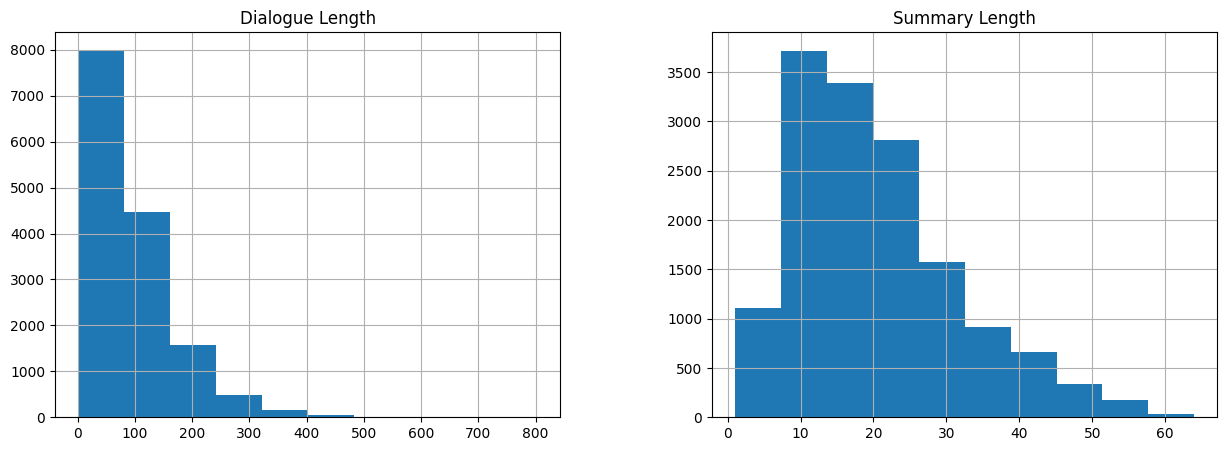

In [ ]:
df.hist(figsize=(15,5))

In [ ]:
#data collator

def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target = batch['summary'],
                        max_length = 1024, truncation=True)
  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}
  return encodings

In [ ]:
summary_data_pt = summary_data.map(get_feature, batched=True)
summary_data_pt

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
columns = ['input_ids','labels','attention_mask']
summary_data_pt.set_format(type='torch',columns = columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_summary',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps =10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args= training_args, tokenizer=tokenizer, data_collator=data_collator, train_dataset = summary_data_pt['train'], eval_dataset= summary_data_pt['validation'])

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=230, training_loss=1.4881303165269935, metrics={'train_runtime': 1879.4778, 'train_samples_per_second': 7.838, 'train_steps_per_second': 0.122, 'total_flos': 8823027777404928.0, 'train_loss': 1.4881303165269935, 'epoch': 1.0})

In [ ]:
trainer.save_model('bart_samsum_news_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [ ]:
!zip bart_samsum_news.zip -r bart_samsum_news_model/

  adding: bart_samsum_news_model/ (stored 0%)
  adding: bart_samsum_news_model/tokenizer.json (deflated 72%)
  adding: bart_samsum_news_model/special_tokens_map.json (deflated 85%)
  adding: bart_samsum_news_model/merges.txt (deflated 53%)
  adding: bart_samsum_news_model/training_args.bin (deflated 51%)
  adding: bart_samsum_news_model/model.safetensors (deflated 7%)
  adding: bart_samsum_news_model/tokenizer_config.json (deflated 76%)
  adding: bart_samsum_news_model/config.json (deflated 61%)
  adding: bart_samsum_news_model/generation_config.json (deflated 47%)
  adding: bart_samsum_news_model/vocab.json (deflated 59%)


In [27]:
pipe = pipeline('summarization', model='bart_samsum_news_model')
gen_kwargs ={'length_penalty': 0.8, 'num_beams': 8,"max_length": 128}

custom_article ="""
"Have you ever heard of the Baobab tree?" asked Emily, gazing at the ancient giant before them.

"The African tree with a thousand legends surrounding it?" replied Jake, intrigued.

"That's the one! Did you know that the Baobab tree lives for thousands of years?" Emily shared, her eyes twinkling with excitement.

"Wow, that's impressive And it's not just its age that's fascinating. The Baobab tree's trunk can store thousands of gallons of water, making it a lifeline for animals in the African savannah," Jake remarked, marveling at nature's ingenuity.

"Exactly! And not to mention its fruit, the 'superfruit' as they call it. Rich in vitamin C, antioxidants, and other nutrients, it's a powerhouse of health benefits," Emily added, her voice filled with wonder.

As they stood beneath the ancient Baobab tree, surrounded by its aura of mystery and wisdom, Jake couldn't help but feel a profound connection to the natural world.

In this paraphrased version, I've condensed and rephrased the original text to capture the essence of the dialogue and the information about the Baobab tree.

"""
print(pipe(custom_article, **gen_kwargs))

[{'summary_text': '"The Baobab tree can store thousands of gallons of water, making it a lifeline for animals in the African savannah, and its fruit, the \'superfruit\' as they call it, is rich in vitamin C, antioxidants, and other nutrients.'}]


In [28]:
custom_article

'\n"Have you ever heard of the Baobab tree?" asked Emily, gazing at the ancient giant before them.\n\n"The African tree with a thousand legends surrounding it?" replied Jake, intrigued.\n\n"That\'s the one! Did you know that the Baobab tree can live for thousands of years?" Emily shared, her eyes twinkling with excitement.\n\n"Wow, that\'s impressive! And it\'s not just its age that\'s fascinating. The Baobab tree\'s trunk can store thousands of gallons of water, making it a lifeline for animals in the African savannah," Jake remarked, marveling at nature\'s ingenuity.\n\n"Exactly! And not to mention its fruit, the \'superfruit\' as they call it. Rich in vitamin C, antioxidants, and other nutrients, it\'s a powerhouse of health benefits," Emily added, her voice filled with wonder.\n\nAs they stood beneath the ancient Baobab tree, surrounded by its aura of mystery and wisdom, Jake couldn\'t help but feel a profound connection to the natural world.\n\nIn this paraphrased version, I\'ve c

In [29]:
len(custom_article)

1099